**Цель проекта**

Исследовать исторические данные о которовках акции компании Google.

Разработать несколько моделей на основе нейронных сетей для прогноза значений котировок акций, которые можно было бы применять на подобных временных рядах

Проверить полученные модели на указанном наборе данных и сравнить их показатели для выбора наиболее оптимальной топологии.

Для анализа будет использоваться значение на момент закрытия торгов (в исходных данных обозначается как Close).

**Данные для исследования:**

Источник данных:
https://www.kaggle.com/datasets/varpit94/google-stock-data

В датасете представленные исторические данные Alphabet Inc. (GOOG). Значения котировок представлены посуточно. Валюта - USD.

In [124]:
# Файл скопирован локально, укажите здесь путь к нему:

path = r'C:\Users\User\Downloads\GOOGL.csv'

**Загрузка библиотек**

In [125]:
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

# Отрисовка графики в ячейке colab
%matplotlib inline

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

# Для анализа статистических моделей 
import statsmodels.api as sm

In [126]:
# Назначение размера и стиля графиков по умолчанию
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

**Загрузка датасета и подготовка данных**

In [127]:
# Чтение данных в таблицу Pandas 
data = pd.read_csv(path)

In [128]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602
...,...,...,...,...,...,...,...
4426,2022-03-18,2668.489990,2724.879883,2645.169922,2722.510010,2722.510010,2223100
4427,2022-03-21,2723.270020,2741.000000,2681.850098,2722.030029,2722.030029,1341600
4428,2022-03-22,2722.030029,2821.000000,2722.030029,2797.360107,2797.360107,1774800
4429,2022-03-23,2774.050049,2791.770020,2756.699951,2765.510010,2765.510010,1257700


**Исследование датасета**

In [129]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4431.000000,4431.000000,4431.000000,4431.000000,4431.000000,4.431000e+03
mean,693.087345,699.735595,686.078751,693.097367,693.097367,6.444992e+06
std,645.118799,651.331215,638.579488,645.187806,645.187806,7.690351e+06
min,49.644646,50.920921,48.028027,50.055054,50.055054,4.656000e+05
25%,248.558563,250.853355,245.813309,248.415916,248.415916,1.695600e+06
50%,434.924927,437.887878,432.687683,435.330322,435.330322,3.778418e+06
75%,1007.364990,1020.649994,997.274994,1007.790008,1007.790008,8.002390e+06
max,3025.000000,3030.929932,2977.979980,2996.770020,2996.770020,8.215117e+07


In [130]:

print(data['Date'].min())
print(data['Date'].max())

2004-08-19
2022-03-24


В датасете содержатся данные о котировках акций с 19 августа 2004 года по 24 марта 2022. Всего 4431 записи.

In [131]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4431 entries, 0 to 4430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4431 non-null   object 
 1   Open       4431 non-null   float64
 2   High       4431 non-null   float64
 3   Low        4431 non-null   float64
 4   Close      4431 non-null   float64
 5   Adj Close  4431 non-null   float64
 6   Volume     4431 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 242.4+ KB


Нет пропущенных значений и выбросов. Очистку данных можно не прозводить. Данные предоставленые с периодичностью в 1 сутки (все временные интервалы между соседними значениями - равные).

In [132]:
# Преобразование столбца даты в индекс таблицы и удаление ненужного столбца даты
data.index = pd.to_datetime(data['Date'])
data.drop(columns='Date', inplace=True)



**Представление данных в графическом виде**

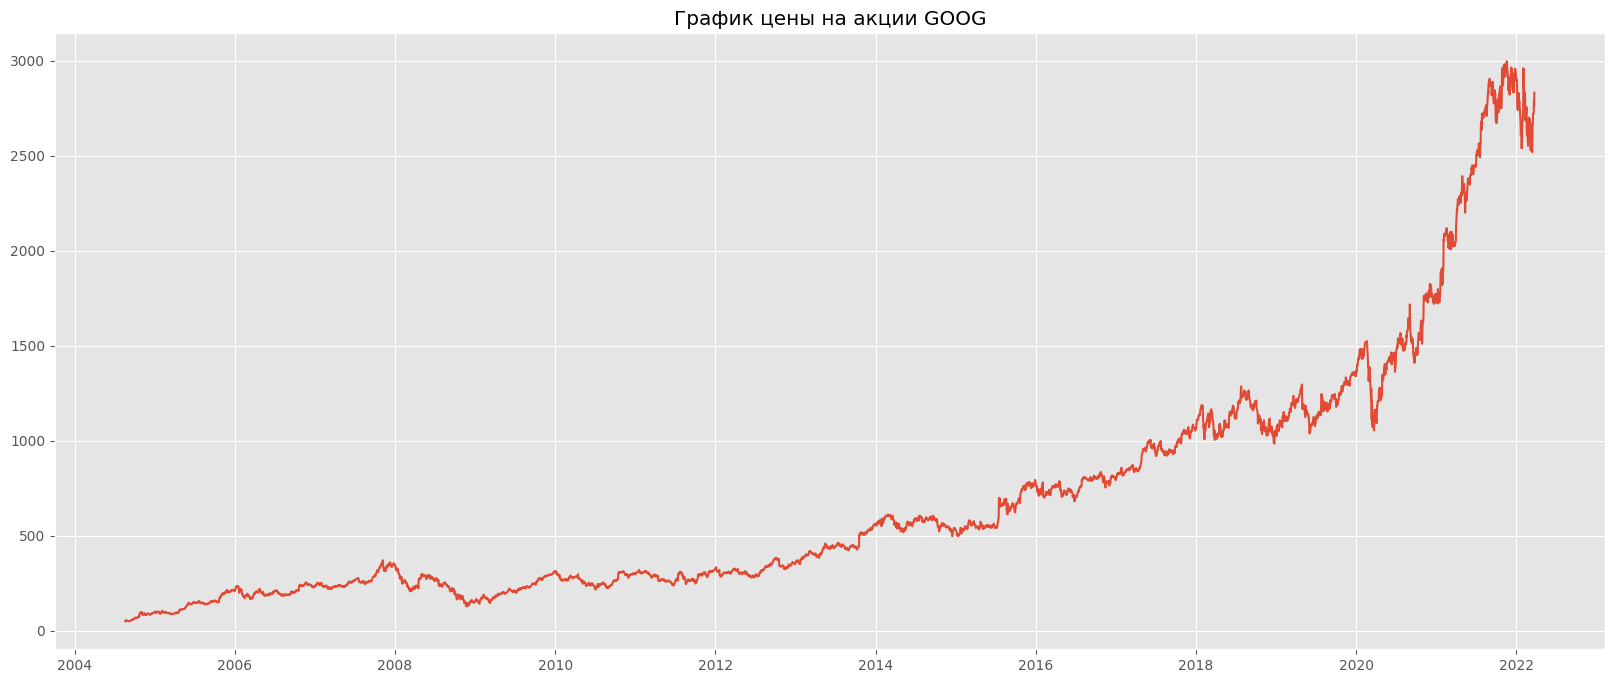

In [133]:
# Отображение временного ряда в графическом виде
plt.figure(figsize=(20, 8))
plt.plot(data.index, data['Close'])
plt.title('График цены на акции GOOG')
plt.show()

In [134]:
# Удалим столбец, не используемый для анализа
data = data.drop(columns=['Adj Close'])

In [135]:
x_data = data['Close'].resample('MS').mean()
x_data.head()

Date
2004-08-01    52.683795
2004-09-01    56.670241
2004-10-01    76.692168
2004-11-01    88.836454
2004-12-01    90.975975
Freq: MS, Name: Close, dtype: float64

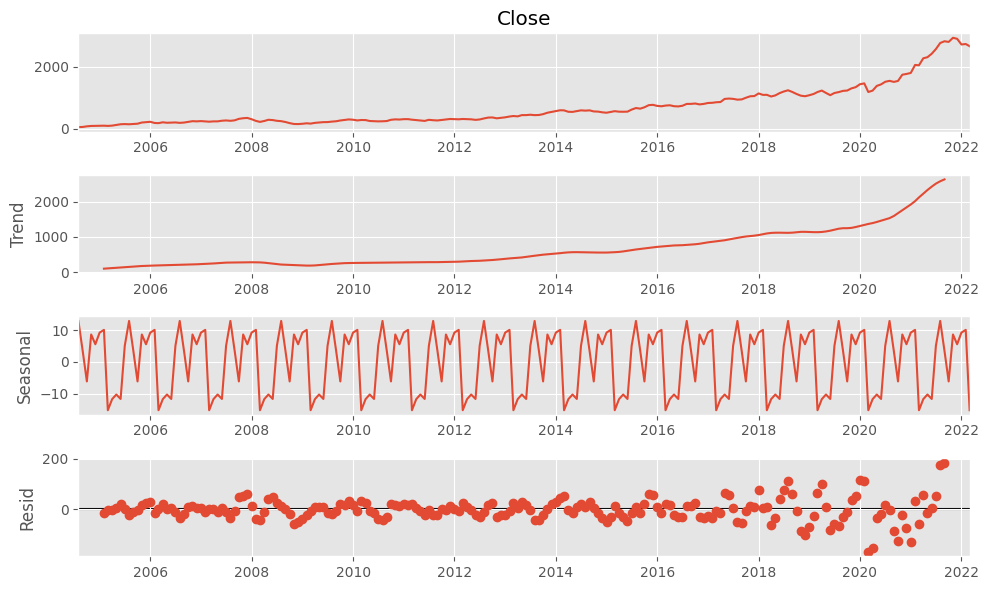

In [137]:
# Разложим временной ряд на составляющие (тренд, сезонность, шум)

rcParams['figure.figsize'] = 10,6
decomposition = sm.tsa.seasonal_decompose(x_data, model = 'additive')
fig = decomposition.plot()
plt.show()

Можно сделать вывод, что ряд нестационарен, так как в нем присутствуют тренд и сезонность

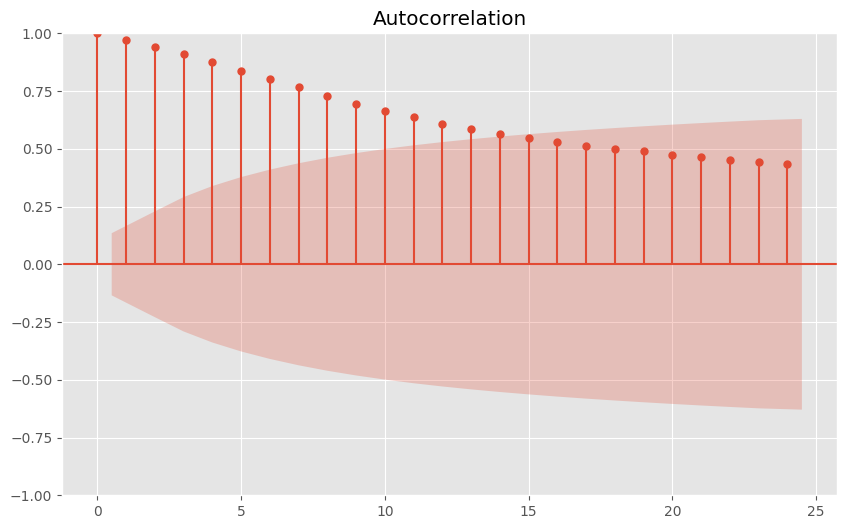

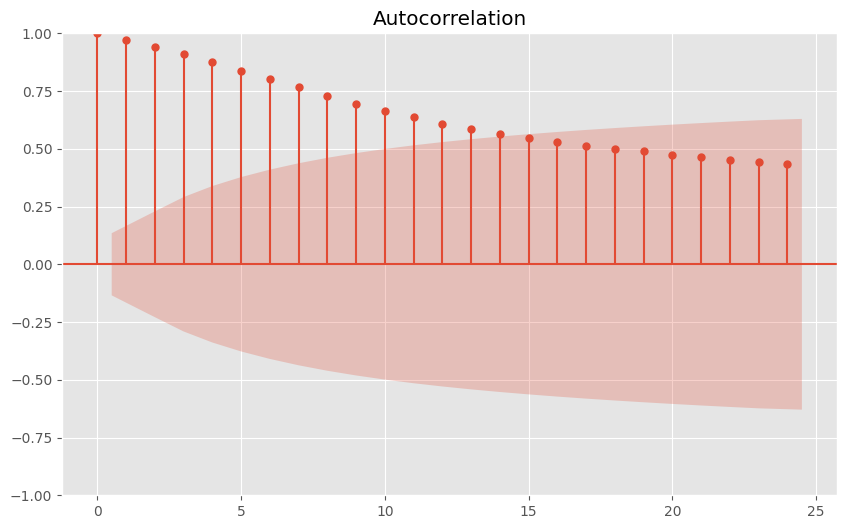

In [138]:
# Построим график автокорреляции

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(x_data)

По коррелограмме присутсвтует тренд, так как максимальное значение корреляции в k = 1, с увеличением величины лага значение коэффициента корреляции понемногу снижается.  

In [139]:
# Задание текстовых меток каналов данных (столбцов)
CHANNEL_NAMES = ['Open', 'High','Low', 'Close', 'Volume']

# Получение словаря с именами и индексами каналов данных
CHANNEL_INDEX = {name: chan for chan, name in enumerate(CHANNEL_NAMES)}

In [140]:
data_np = data.to_numpy()

In [19]:
data_np

array([[5.00500490e+01, 5.20820810e+01, 4.80280270e+01, 5.02202190e+01,
        4.46590960e+07],
       [5.05555570e+01, 5.45945970e+01, 5.03003010e+01, 5.42092090e+01,
        2.28343430e+07],
       [5.54304310e+01, 5.67967990e+01, 5.45795780e+01, 5.47547530e+01,
        1.82561260e+07],
       ...,
       [2.72203003e+03, 2.82100000e+03, 2.72203003e+03, 2.79736011e+03,
        1.77480000e+06],
       [2.77405005e+03, 2.79177002e+03, 2.75669995e+03, 2.76551001e+03,
        1.25770000e+06],
       [2.78400000e+03, 2.83237988e+03, 2.75501001e+03, 2.83143994e+03,
        1.31790000e+06]])

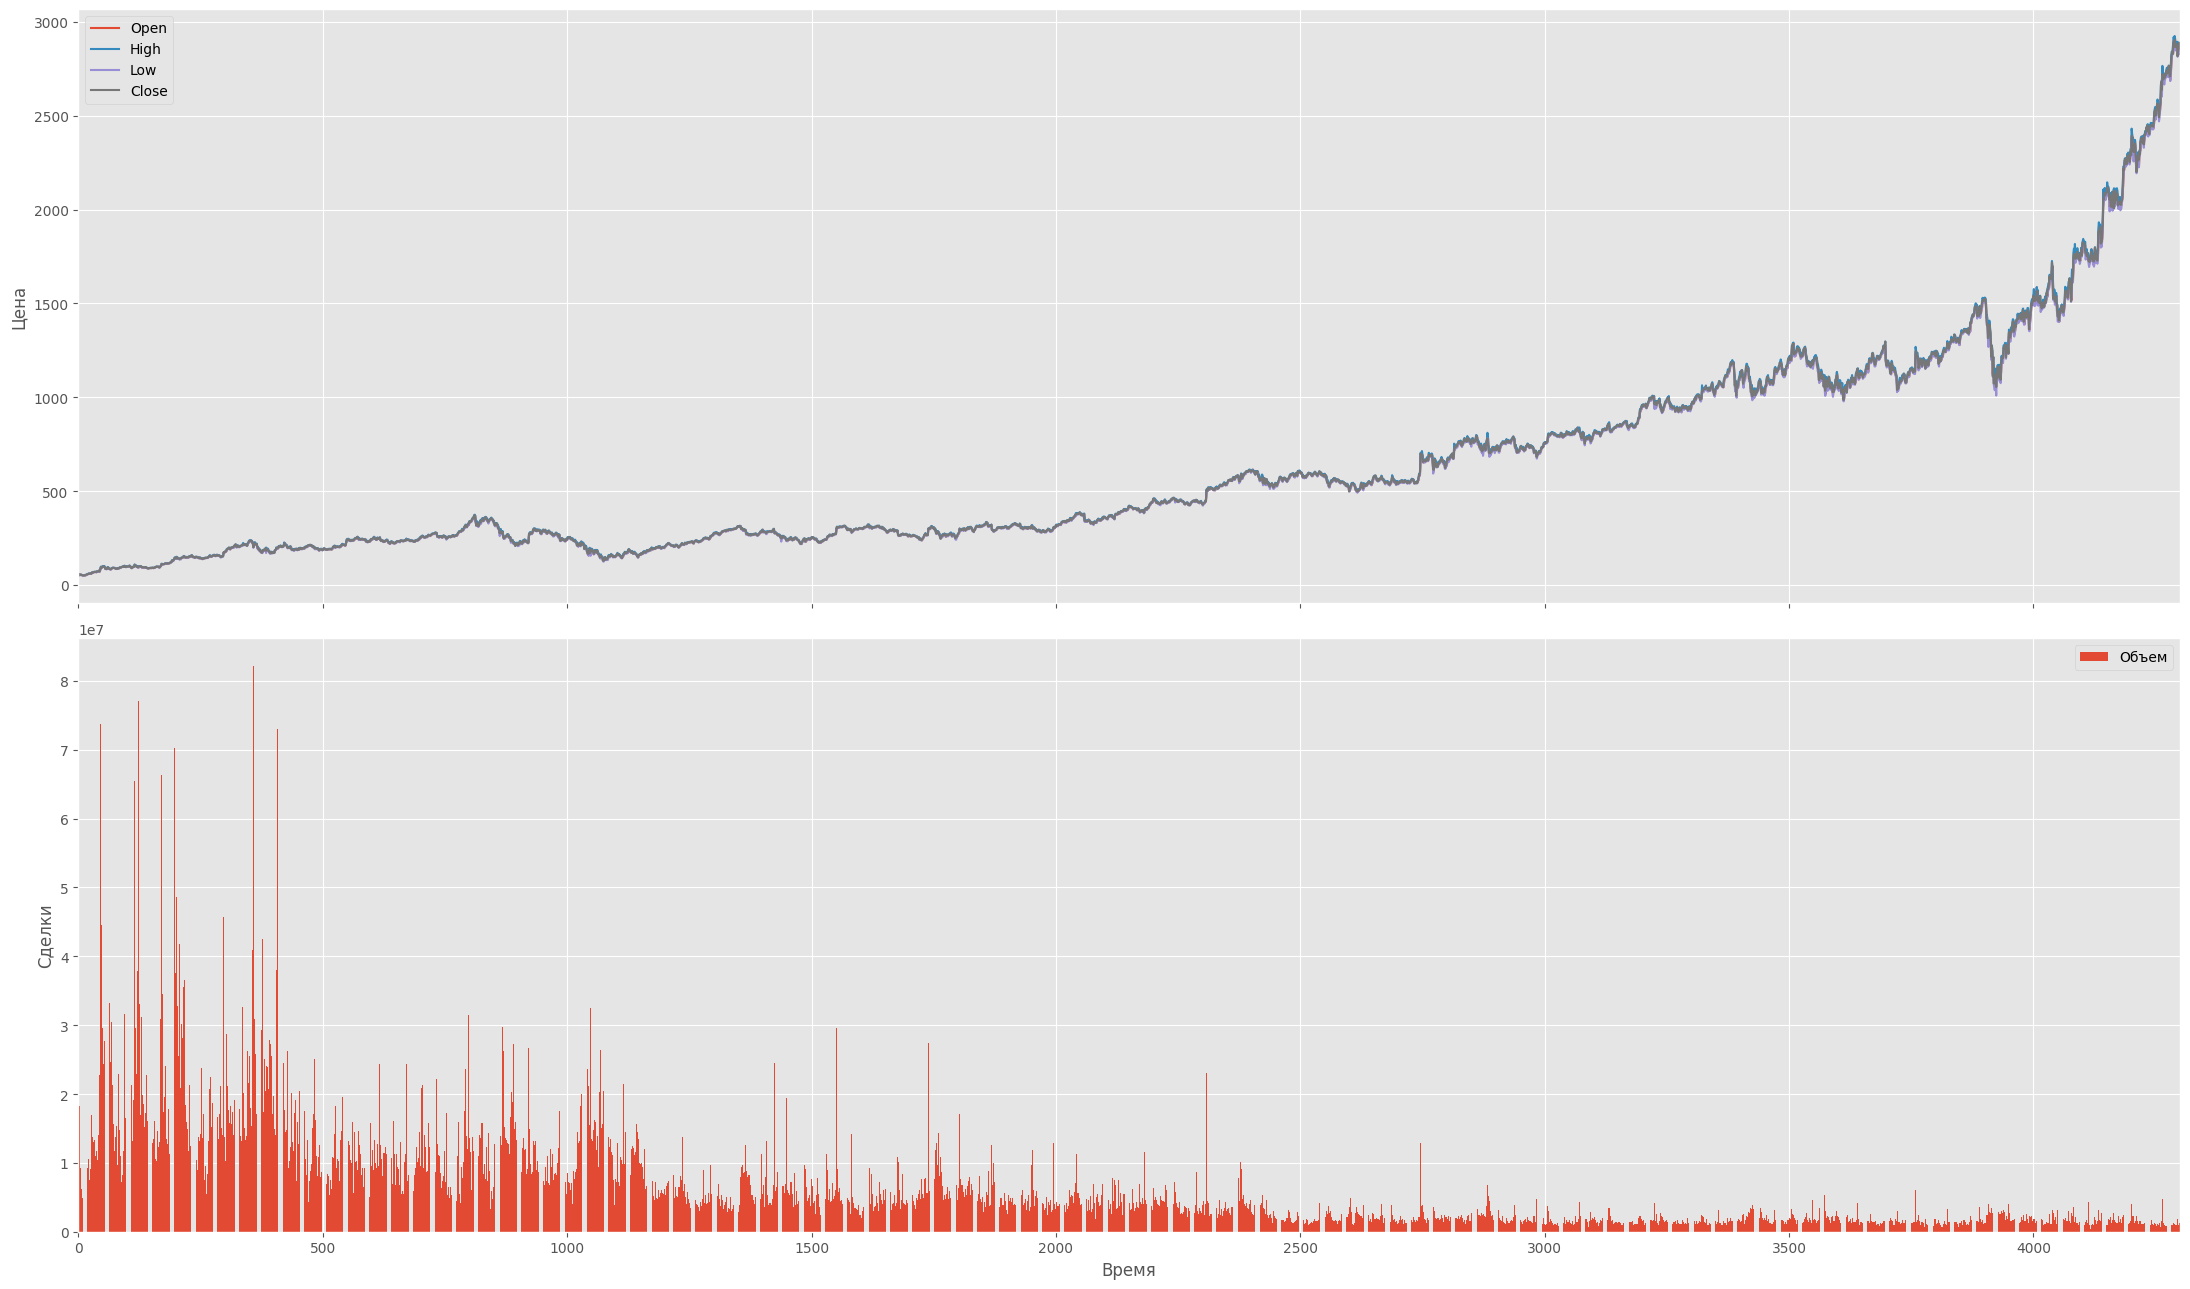

In [144]:
# Отображение исходных данных от точки start и длиной length
start = 0
length = 4300

# Задание полотна для графиков - два подграфика один под другим с общей осью x
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(22, 13), sharex=True)

# Четыре основных канала - open, high, low, close
for chn in range(4):
    # Отрисовка одного канала данных
    # От начальной точки start длиной length
    ax1.plot(data_np[start:start + length, chn],
             label=CHANNEL_NAMES[chn])
ax1.set_ylabel('Цена')
ax1.legend()

# Канал volume (объем)
ax2.bar(x=np.arange(length),
        height=data_np[start:start + length, CHANNEL_INDEX['Volume']],
        label='Объем')
ax2.set_ylabel('Сделки')
ax2.legend()

plt.xlabel('Время')
# Регулировка пределов оси x
plt.xlim(0, length)
# Указание расположить подграфики плотнее друг к другу
plt.tight_layout()
# Фиксация графика
plt.show()

In [145]:
# Словарь каналов данных с их индексами
print(CHANNEL_INDEX)

{'Open': 0, 'High': 1, 'Low': 2, 'Close': 3, 'Volume': 4}


In [146]:
data_np.shape

(4431, 5)

**Решение задачи прогнозирования временного ряда**

In [147]:
# Применим статистический тест для оценки стационарности ряда
 

from statsmodels.tsa.stattools import adfuller

result = adfuller(x_data)

if result[0] > result[4]['5%']: 
    print ('Ряд нестационарен')
else:
    print ('Ряд стационарен')

Ряд нестационарен


Ряд нестационарен, потом AR модель к нему не применима. Но можноиспользовать модель SARIMA (Seasonal ARIMA), которая учитывает и тренд (благодаря скользящему среднему), и зависимость от предыдущих значений (благодаря авторегрессии), и сезонность.

In [149]:
# Подберем автоматически оптимальные параметры для модели
 
import pmdarima as pmd

model=pmd.auto_arima(x_data,start_p=1,start_q=1,test='adf',m=12,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=2256.836, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2261.207, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2253.780, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2254.400, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2271.328, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2256.192, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2254.583, Time=0.48 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2255.168, Time=0.32 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2254.544, Time=0.17 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=2256.377, Time=0.55 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2262.485, Time=0.13 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=2255.629, Time=0.26 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=2255.435, Time=0.35 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2253.438, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0

In [150]:
# обучим модель SARIMAX
from statsmodels.tsa.api import SARIMAX


train_data = x_data[:len(x_data)-50]
test_data = x_data[len(x_data)-50:]
# Инициализируем и обучим модель. 

sarima_model = SARIMAX(train_data,order=(0,1,1),seasonal_order=(1,0,0,12)).fit()
print(sarima_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                  162
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 12)   Log Likelihood                -735.674
Date:                             Sun, 10 Mar 2024   AIC                           1477.348
Time:                                     16:57:52   BIC                           1486.592
Sample:                                 08-01-2004   HQIC                          1481.102
                                      - 01-01-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3528      0.078      4.528      0.000       0.200       0.505
ar.S.L12       0.0176      

In [151]:
pred = sarima_model.predict(start=0, end=(len(x_data)-1), dynamic=False)

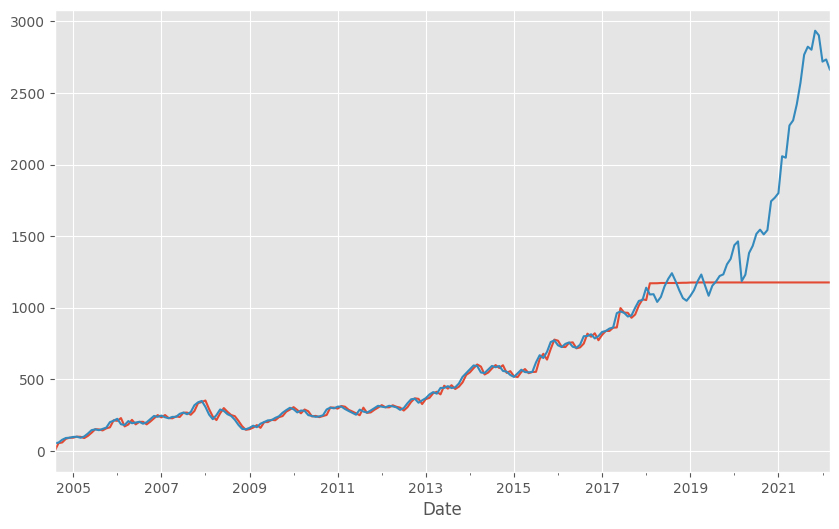

In [152]:

fig = pred.plot()
fig = x_data.plot()
plt.show()

Модель хорошо предсказывает данные, которые были поданы ей в тестовой выборке, но плохо прогнозирует значения на неизвестном ей периоде.

Ввиду сложности временного ряда попробуем использовать для решения задачи прогноза временного рядо модели на основе нейронных сетей.

**Разработка нейросетевых моделей для решения задачи прогнозирования временного ряда**

In [153]:
# Задание гиперпараметров

CHANNEL_X = CHANNEL_NAMES                 # Отбор каналов входных данных
CHANNEL_Y = ['Close']                     # Отбор каналов данных для предсказания
SEQ_LEN = 100                             # Длина прошедших данных для анализа
BATCH_SIZE = 20                           # Объем батча для генератора
TEST_LEN = 500                            # Объем тестовой выборки
TRAIN_LEN = data.shape[0] - TEST_LEN      # Объем обучающей выборки

In [156]:
# Формирование списков индексов каналов данных для входных и выходных выборок
chn_x = [CHANNEL_INDEX[c] for c in CHANNEL_X]
chn_y = [CHANNEL_INDEX[c] for c in CHANNEL_Y]

# Проверка результата
print(chn_x, chn_y)


[0, 1, 2, 3, 4] [3]


In [118]:

# Разделение данных на тренировочный и тестовый наборы
# 2*SEQ_LEN - для разрыва между тренировочными и тестовыми данными
# варьируемый параметр, страховка от пересечения
data_train, data_test = data[:TRAIN_LEN], data[TRAIN_LEN + 2*SEQ_LEN:]

# Отбор входных данных
x_data_train, x_data_test = data_train[:, chn_x], data_test[:, chn_x]




In [119]:
x_data_train

array([[5.00500490e+01, 5.20820810e+01, 4.80280270e+01, 5.02202190e+01,
        4.46590960e+07],
       [5.05555570e+01, 5.45945970e+01, 5.03003010e+01, 5.42092090e+01,
        2.28343430e+07],
       [5.54304310e+01, 5.67967990e+01, 5.45795780e+01, 5.47547530e+01,
        1.82561260e+07],
       ...,
       [1.12746997e+03, 1.15105005e+03, 1.10400000e+03, 1.11026001e+03,
        3.13970000e+06],
       [1.13264001e+03, 1.15100000e+03, 1.09848999e+03, 1.14631006e+03,
        2.93680000e+06],
       [1.14872998e+03, 1.17340002e+03, 1.13671997e+03, 1.16194995e+03,
        3.26140000e+06]])

In [115]:

# Масштабирование данных
x_scaler = MinMaxScaler()
x_scaler.fit(x_data_train)
x_data_train = x_scaler.transform(x_data_train)
x_data_test = x_scaler.transform(x_data_test)

# Отбор выходных данных
y_data_train, y_data_test = data_train[:, chn_y], data_test[:, chn_y]

# Масштабирование данных
y_scaler = MinMaxScaler()
y_scaler.fit(y_data_train)
y_data_train = y_scaler.transform(y_data_train)
y_data_test = y_scaler.transform(y_data_test)


ValueError: Expected 2D array, got 1D array instead:
array=[  52.68379511   56.67024129   76.69216848   88.8364541    90.97597532
   96.51951935   97.60444716   90.66976095   99.70708829  119.97497481
  143.91664405  149.2550041   143.60534283  152.27203448  161.39663471
  199.76738643  209.68563695  223.07907955  185.18544895  179.61374296
  207.09604368  192.08981664  196.99381186  201.9692207   188.73308065
  198.72972945  220.48776173  243.05924771  236.9854865   245.5360359
  233.84252674  226.68259155  236.48548515  236.74219786  257.76824167
  266.50650529  255.17038691  270.48390121  318.01344896  338.52114143
  348.0470489   306.21145195  252.1499024   220.38738865  249.03790145
  288.24729567  278.43605267  255.26913314  243.19653038  216.2767531
  180.1481927   152.40556174  149.922649    159.54053875  174.97102353
  164.49404005  189.02640567  200.2139641   212.10437845  213.85954155
  229.18918943  240.57557471  265.37674232  283.7437409   299.94517245
  289.59011353  267.714296    280.79579352  278.81000038  248.9154144
  242.478386    236.71981438  239.89648709  247.5148969   288.25754367
  301.30678157  296.07425495  308.03428665  308.727939    291.4185937
  277.55955655  264.94446819  251.70101791  287.1606613   273.84645796
  266.35182548  281.15234295  297.52371362  313.98326919  307.75225065
  303.50175325  313.95008714  310.0255249   302.99708973  285.59798043
  298.32332219  331.58875835  359.51056711  363.39148243  335.39205781
  352.0009995   367.46055829  393.36625905  409.40114755  398.60132664
  438.75784995  439.06781615  451.16002173  437.95977923  443.09109495
  469.81720504  515.94319605  542.718192    568.75612976  595.68384121
  591.81443562  546.56005562  542.98047743  567.28237776  592.48545964
  583.33761738  592.12952829  557.54348083  552.54421179  529.19318323
  515.91949775  540.98579163  565.96590636  549.48238414  547.6765014
  550.796814    617.46500191  667.65713929  647.78856548  691.55545327
  759.63899845  771.04000032  736.65684426  724.3899964   746.78727023
  756.60856995  726.52952362  719.58500536  741.07350465  800.20999539
  801.62143376  813.64000019  784.73617981  800.62429086  830.24950865
  836.75473511  853.79000196  861.37789763  961.65454932  973.36863855
  963.4435059   937.96087387  945.88449705  999.14500564 1046.98334624
 1053.91748665 1139.394293  ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [97]:

# Проверка формы данных
print(f'Train data: {x_data_train.shape}, {y_data_train.shape}')
print(f'Test  data: {x_data_test.shape}, {y_data_test.shape}')

# Создание генератора для обучения
train_datagen = TimeseriesGenerator(x_data_train,
                                    y_data_train,
                                    length=SEQ_LEN,
                                    stride=1,
                                    sampling_rate=1,
                                    batch_size=BATCH_SIZE)

# Аналогичный генератор для валидации при обучении
val_datagen = TimeseriesGenerator(x_data_test,
                                  y_data_test,
                                  length=SEQ_LEN,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)

# Проверка формы выдаваемого генератором результата
print(f'Train batch x: {train_datagen[0][0].shape}, y: {train_datagen[0][1].shape}')

Train data: (3931, 5), (3931, 1)
Test  data: (300, 5), (300, 1)
Train batch x: (20, 100, 5), y: (20, 1)


In [98]:
# Генератор тестовой выборки, генерирует один батч на всю выборку
test_datagen = TimeseriesGenerator(x_data_test,
                                   y_data_test,
                                   length=SEQ_LEN,
                                   stride=1,
                                   sampling_rate=1,
                                   batch_size=x_data_test.shape[0])

# Формирование тестовой выборки из генератора
x_test, y_test = test_datagen[0]

# Проверка формы тестовой выборки
print(f'Test x: {x_test.shape}, y: {y_test.shape}')

Test x: (200, 100, 5), y: (200, 1)


In [99]:
# Функция расчета результата прогнозирования сети (предсказания)

def get_pred(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler): # масштабирующий объект для y

    # Вычисление и деномализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled

In [100]:
# Функция расчета корреляционного коэффициента Пирсона для двух рядов

def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]

In [101]:
# Функция визуализации результата предсказания сети и верных ответов

def show_predict(y_pred, y_true, # прогноз данных и исходный ряд
                 start, # точка ряда, с которой начинается отрисовка графика
                 length, # количество точек для отрисовки графика
                 chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
                 chn_names=CHANNEL_Y, # список имен каналов данных
                 title=''):

    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    # Построение графика по всем каналам данных
    plt.figure(figsize=(22, 6))

    for chn in chn_list:
        plt.plot(y_pred[start:start + length, chn],
                label=f'{chn_names[chn]} Прогноз')
        plt.plot(y_true[start:start + length, chn],
                label=f'{chn_names[chn]} Базовый')

    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Данные')
    plt.legend()
    plt.show()

In [102]:
# Функция рисования корреляций прогнозного ряда и исходного со смещением

def show_corr(y_pred, y_true, # прогноз данных и исходный ряд
              back_steps_max=30, # максимальное количество шагов смещения назад по времени
              chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
              chn_names=CHANNEL_Y,
              title=''): # список имен каналов данных

    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    y_len = y_true.shape[0]
    steps = range(0, back_steps_max + 1)

    # Построение графика по всем каналам данных
    plt.figure(figsize=(14, 7))

    for chn in chn_list:
        # Вычисление коэффициентов корреляции базового ряда и предсказания с разным смещением
        cross_corr = [correlate(y_true[:y_len - step, chn], y_pred[step:, chn]) for step in steps]
        # Вычисление коэффициентов автокорреляции базового ряда с разным смещением
        auto_corr = [correlate(y_true[:y_len - step, chn], y_true[step:, chn]) for step in steps]

        plt.plot(cross_corr, label=f'{chn_names[chn]} Прогноз')
        plt.plot(auto_corr, label=f'{chn_names[chn]} Эталон')

    plt.title(title)

    # Назначение меток шкалы оси x
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

In [103]:
# Функция визуализации результата работы сети

def eval_net(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler, # нормировщик выхода
             start=0, length=500, back_steps_max=30, # параметры отображения графиков
             title=''):

    # Получение денормализованного предсказания и данных базового ряда
    y_pred, y_true = get_pred(model, x_test, y_test, y_scaler)

    # Отрисовка графика сопоставления базового и прогнозного рядов
    # Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед
    show_predict(y_pred[1:], y_true[:-1], start, length,
                 title=f'{title}: Сопоставление базового и прогнозного рядов')
    # Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
    show_corr(y_pred, y_true, back_steps_max=back_steps_max,
              title=f'{title}: Корреляционные коэффициенты по шагам смещения')

In [104]:
# Функция обучения модели и отрисовки прогресса и оценки результатов

def train_eval_net(model, # модель
                   train_datagen, val_datagen, # генераторы обучающей и проверочной выборок
                   epoch_list, # список эпох в виде [(epochs1, opt1), (epochs2, opt2), ...]
                   x_test, y_test,
                   y_scaler,
                   start=0,
                   length=500,
                   back_steps_max=30,
                   title=''):

    # Отображение сводки модели
    model.summary()

    # Обучение модели в несколько фаз в соответствии со списком epoch_list
    for epochs, opt in epoch_list:
        # Компиляция модели
        model.compile(loss='mse', optimizer=opt)
        # Фаза обучения модели
        print(f'Обучение {epochs} эпох')
        history = model.fit(train_datagen,
                            epochs=epochs,
                            validation_data=val_datagen,
                            verbose=1)

        # Рисование графиков прошедшей фазы обучения
        fig = plt.figure(figsize=(14, 7))
        plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
        plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
        plt.title(f'{title}: График прогресса обучения')
        # Указание показывать только целые метки шкалы оси x
        fig.gca().xaxis.get_major_locator().set_params(integer=True)
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Средняя ошибка')
        plt.legend()
        plt.show()

        # Рисование графиков оценки результата работы модели после фазы обучения
        eval_net(model, x_test, y_test, y_scaler, start=start,
                 length=length, back_steps_max=back_steps_max, title=title)

**Топология 1 - Простая полносвязная сеть**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100, 150)          900       
                                                                 
 flatten (Flatten)           (None, 15000)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 15001     
                                                                 
Total params: 15,901
Trainable params: 15,901
Non-trainable params: 0
_________________________________________________________________
Обучение 50 эпох
Epoch 1/50
192/192 [==============================] - 1s 3ms/step - loss: 0.0264 - val_loss: 0.9414
Epoch 2/50
192/192 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0154
Epoch 3/50
192/192 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0146

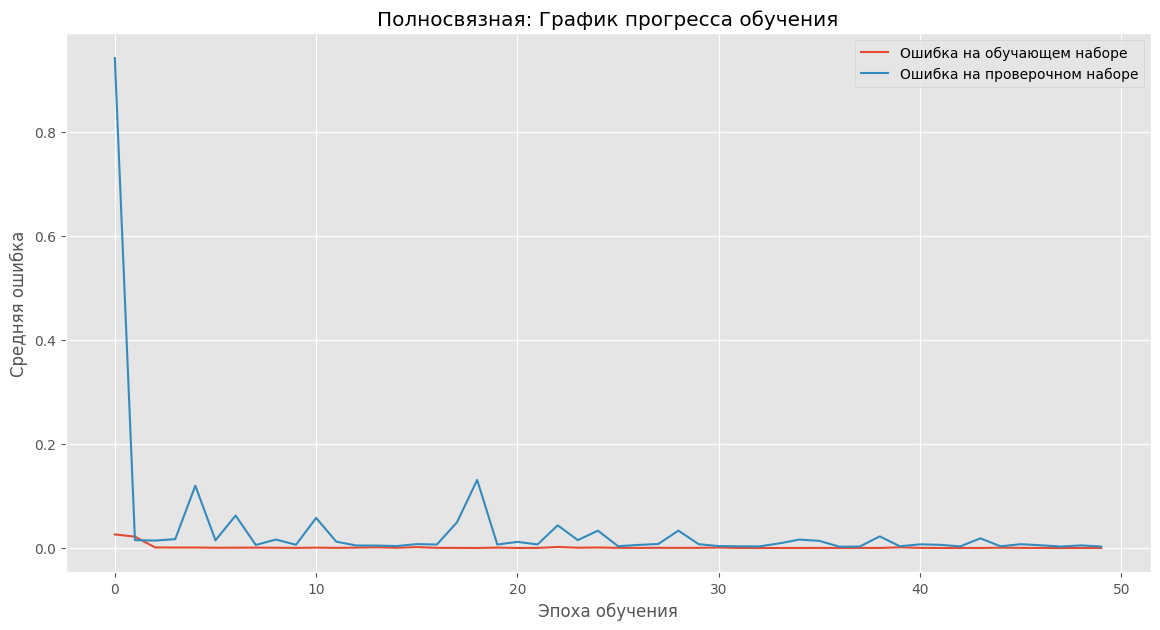

7/7 [==============================] - 0s 2ms/step


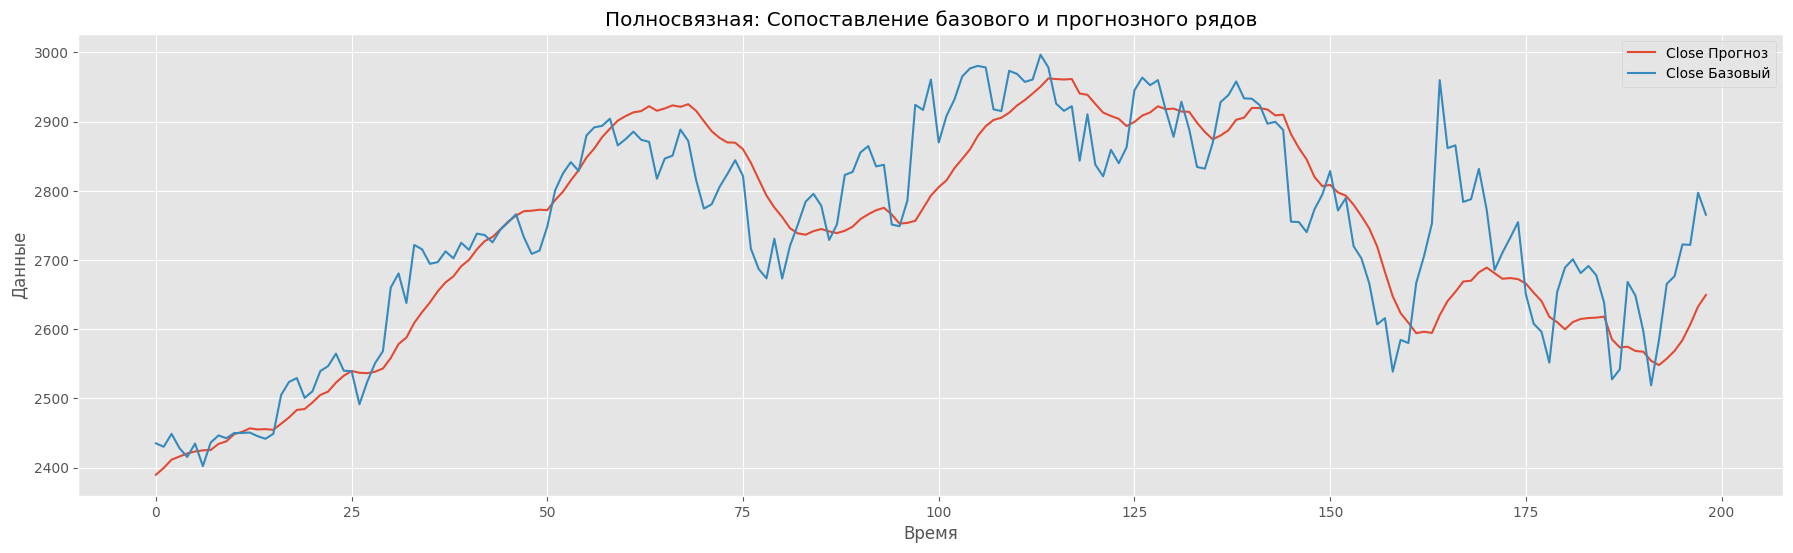

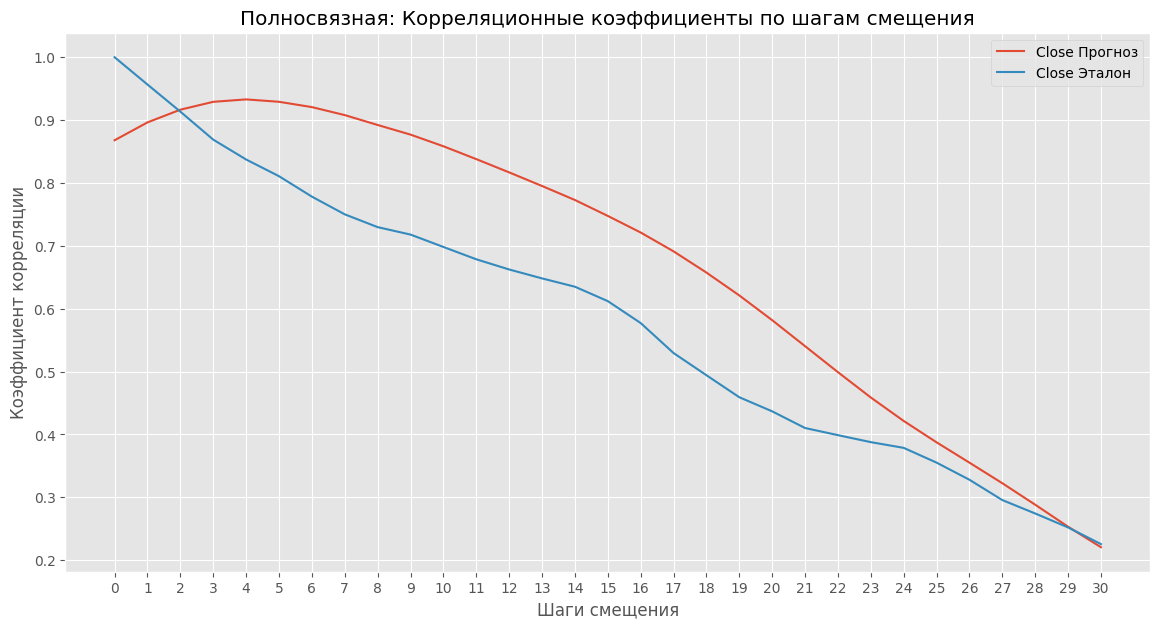

Обучение 50 эпох
Epoch 1/50
192/192 [==============================] - 1s 3ms/step - loss: 6.6230e-04 - val_loss: 0.0035
Epoch 2/50
192/192 [==============================] - 0s 3ms/step - loss: 3.7198e-04 - val_loss: 0.0033
Epoch 3/50
192/192 [==============================] - 0s 2ms/step - loss: 3.6297e-04 - val_loss: 0.0032
Epoch 4/50
192/192 [==============================] - 0s 2ms/step - loss: 3.1832e-04 - val_loss: 0.0053
Epoch 5/50
192/192 [==============================] - 0s 2ms/step - loss: 3.3528e-04 - val_loss: 0.0038
Epoch 6/50
192/192 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 0.0038
Epoch 7/50
192/192 [==============================] - 0s 3ms/step - loss: 4.0847e-04 - val_loss: 0.0034
Epoch 8/50
192/192 [==============================] - 0s 2ms/step - loss: 3.1364e-04 - val_loss: 0.0055
Epoch 9/50
192/192 [==============================] - 0s 2ms/step - loss: 2.9820e-04 - val_loss: 0.0059
Epoch 10/50
192/192 [==============================

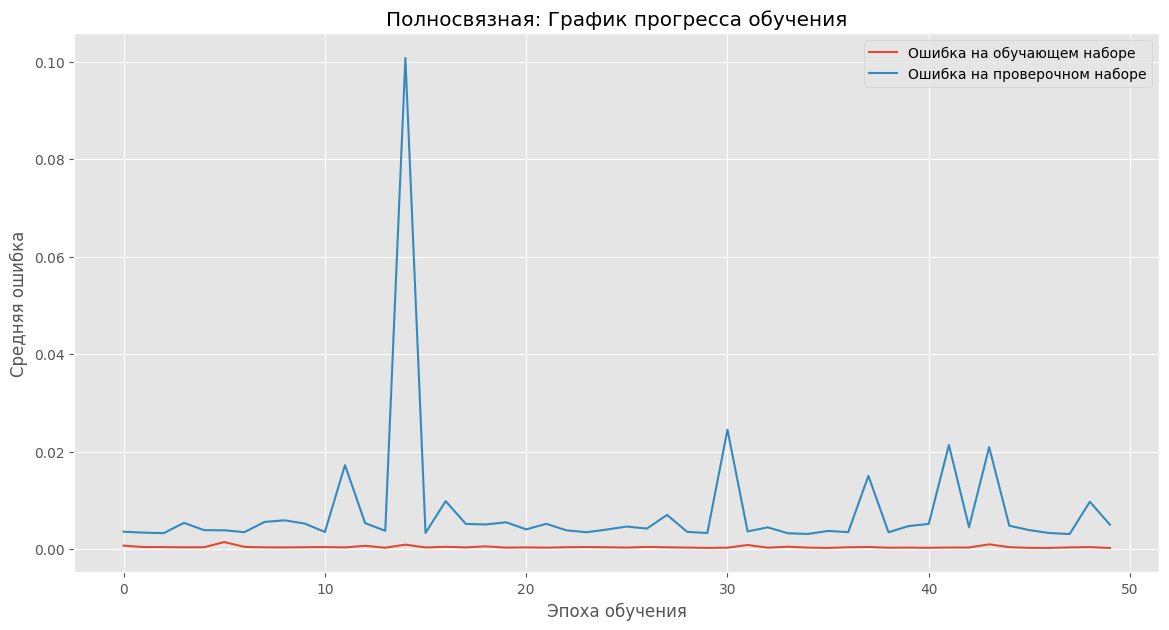

7/7 [==============================] - 0s 1ms/step


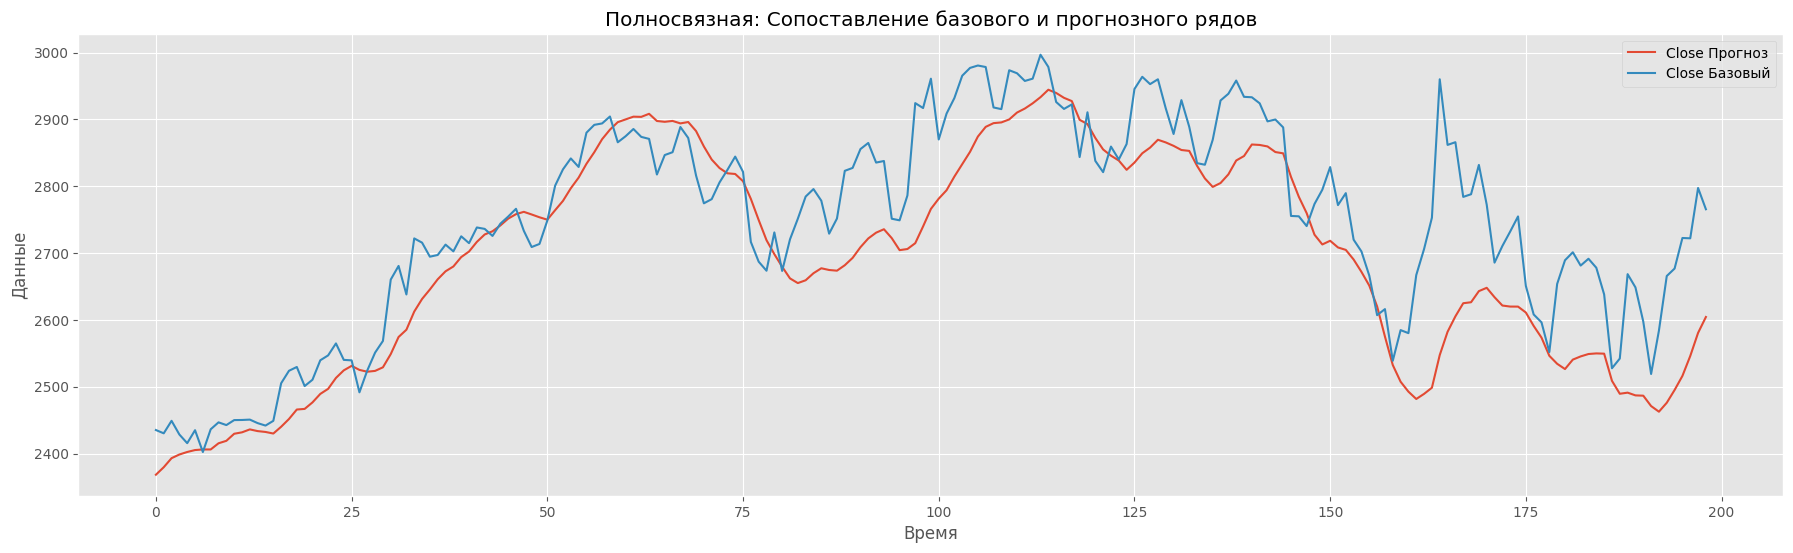

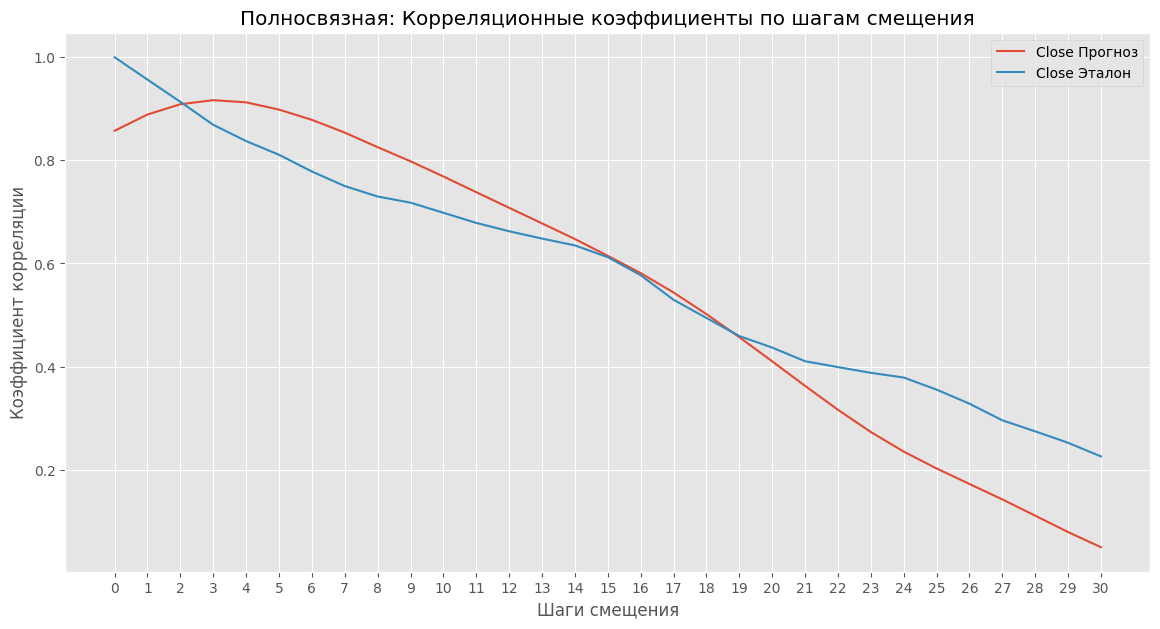

Обучение 50 эпох
Epoch 1/50
192/192 [==============================] - 1s 3ms/step - loss: 3.1326e-04 - val_loss: 0.0053
Epoch 2/50
192/192 [==============================] - 1s 3ms/step - loss: 4.1017e-04 - val_loss: 0.0030
Epoch 3/50
192/192 [==============================] - 1s 3ms/step - loss: 2.5820e-04 - val_loss: 0.0059
Epoch 4/50
192/192 [==============================] - 1s 3ms/step - loss: 2.2167e-04 - val_loss: 0.0033
Epoch 5/50
192/192 [==============================] - 0s 3ms/step - loss: 4.2190e-04 - val_loss: 0.0033
Epoch 6/50
192/192 [==============================] - 0s 2ms/step - loss: 2.6443e-04 - val_loss: 0.0058
Epoch 7/50
192/192 [==============================] - 0s 2ms/step - loss: 2.3887e-04 - val_loss: 0.0036
Epoch 8/50
192/192 [==============================] - 0s 3ms/step - loss: 2.9474e-04 - val_loss: 0.0046
Epoch 9/50
192/192 [==============================] - 0s 2ms/step - loss: 4.0256e-04 - val_loss: 0.0035
Epoch 10/50
192/192 [==========================

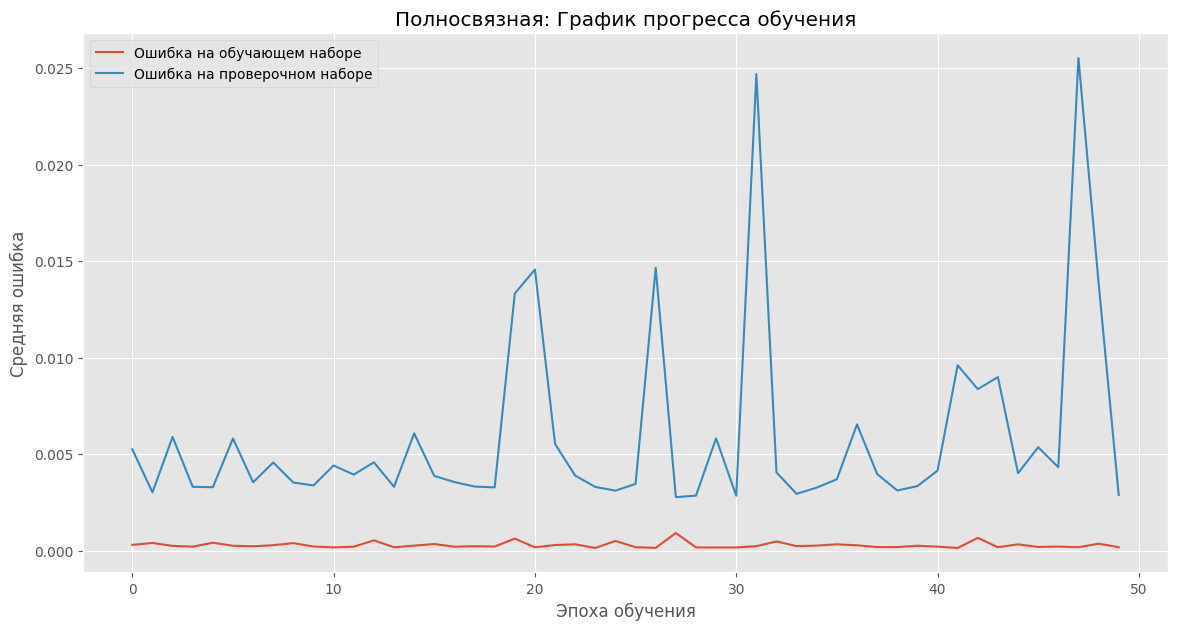

7/7 [==============================] - 0s 2ms/step


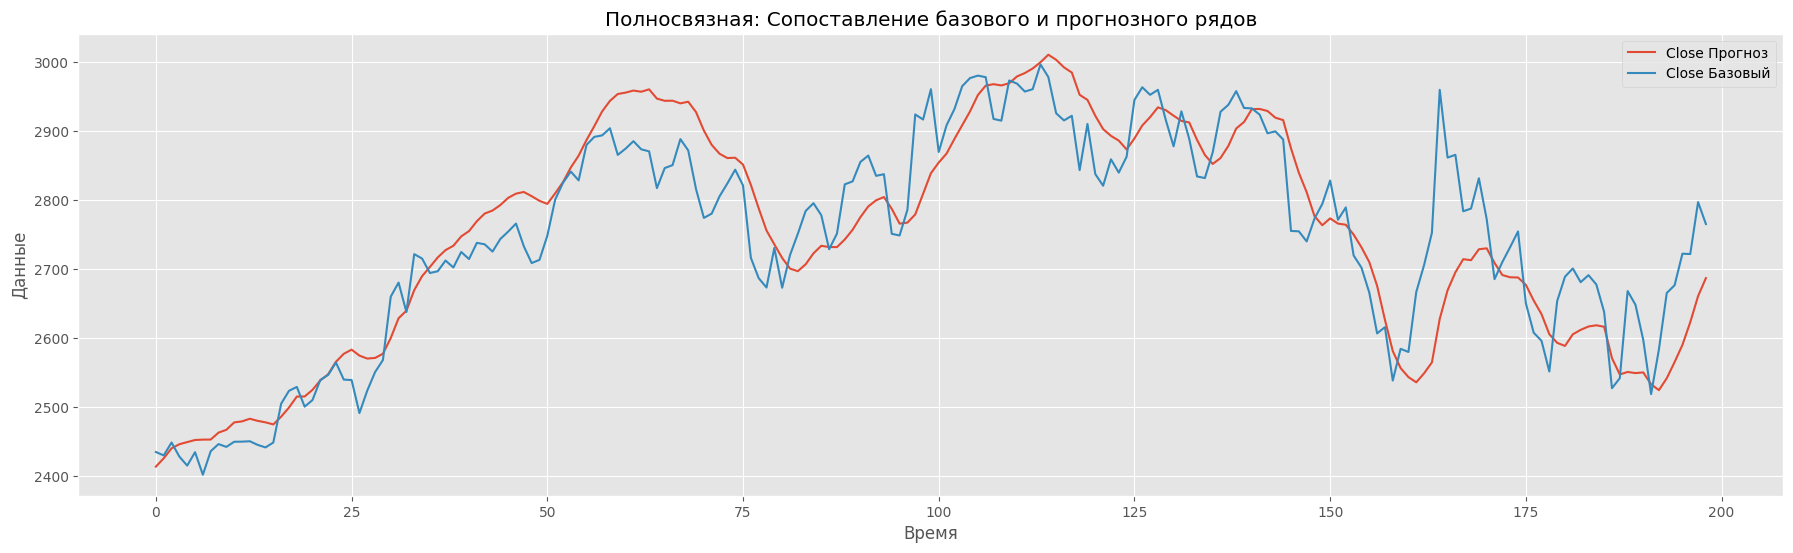

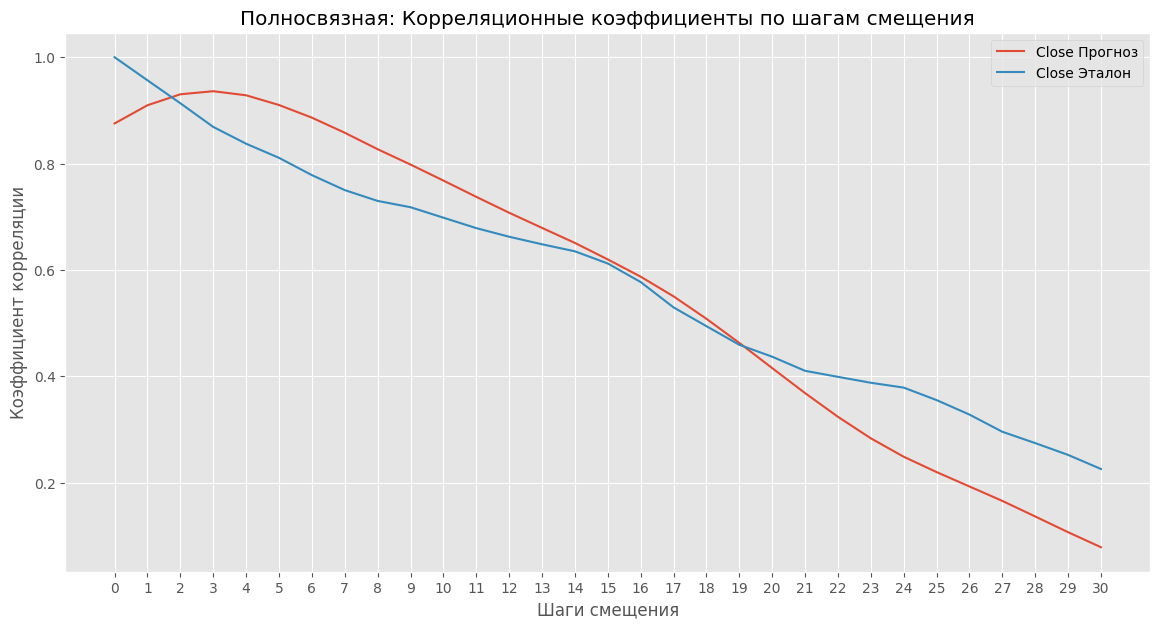

In [105]:
# Простая полносвязная сеть
model_dense = Sequential()
model_dense.add(Dense(150, input_shape=x_test.shape[1:], activation='relu'))
model_dense.add(Flatten())
model_dense.add(Dense(y_test.shape[1], activation='linear'))

# Обучение модели 3x50 эпох
train_eval_net(model_dense, train_datagen, val_datagen, [(50, Adam(lr=1e-4)),
                                                         (50, Adam(lr=1e-5)),
                                                         (50, Adam(lr=1e-6))],
               x_test, y_test, y_scaler, title='Полносвязная')

**Топология 2 - Модель с одномерной сверткой**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 96, 64)            1664      
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 64)            20544     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 46, 64)           0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 2944)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               294500    
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                      

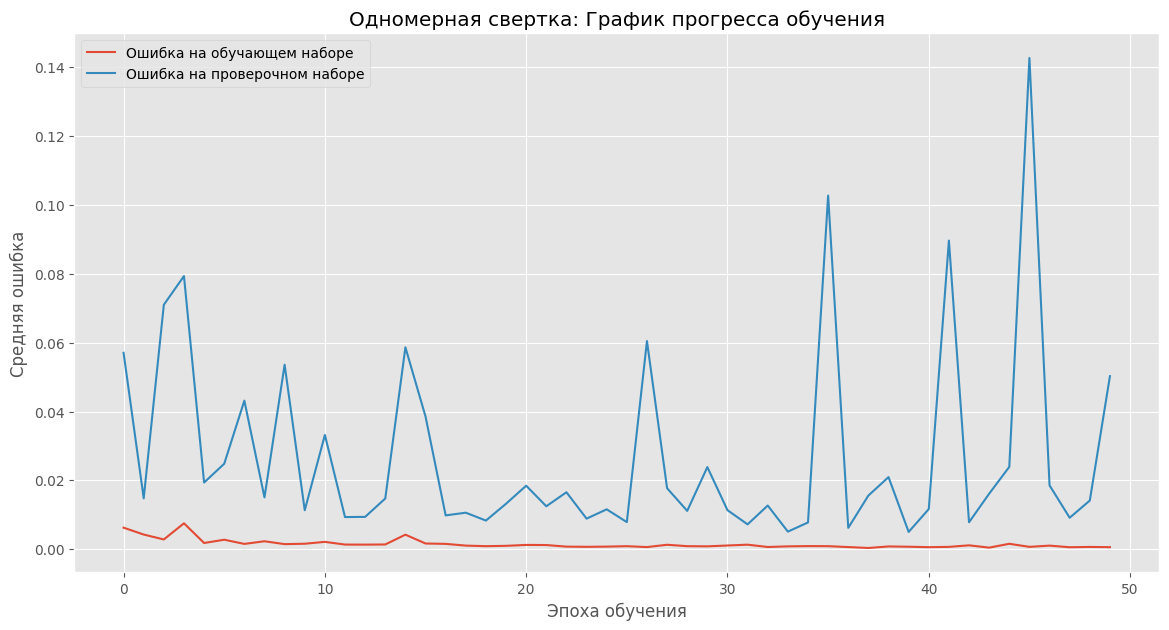

7/7 [==============================] - 0s 2ms/step


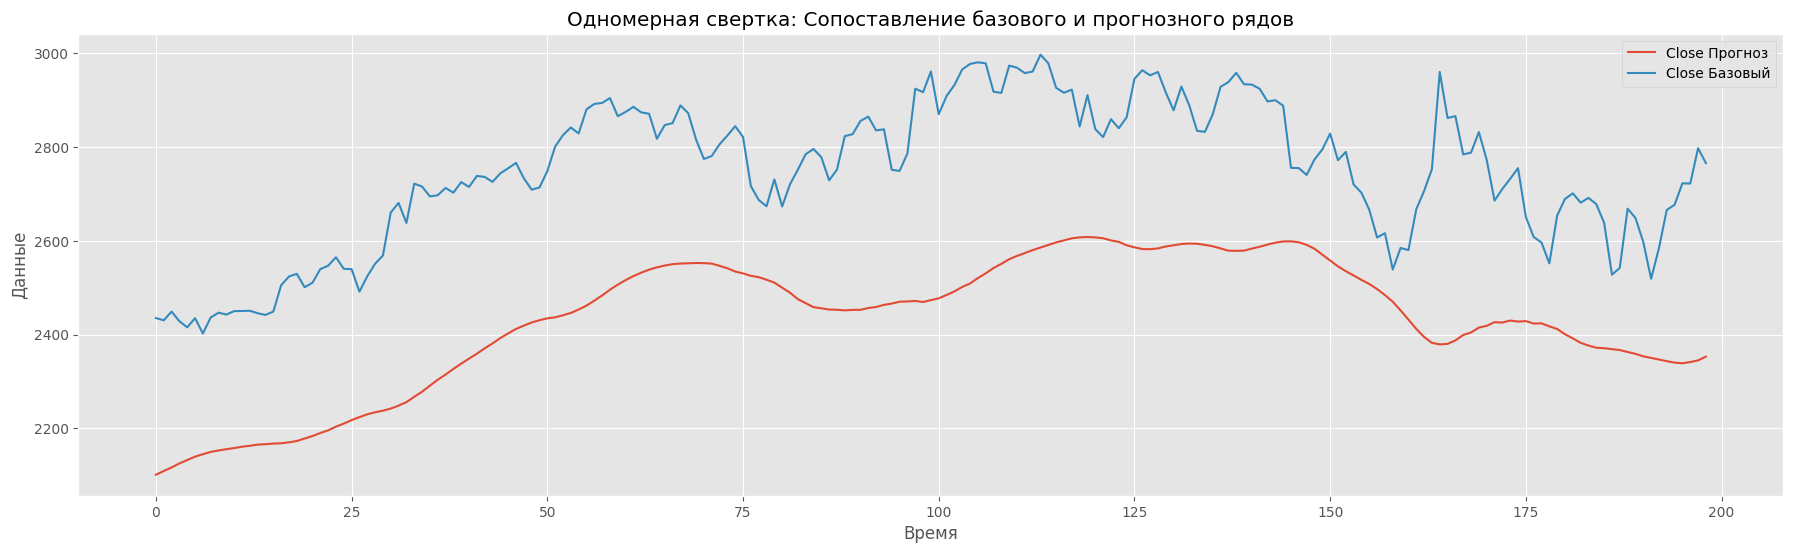

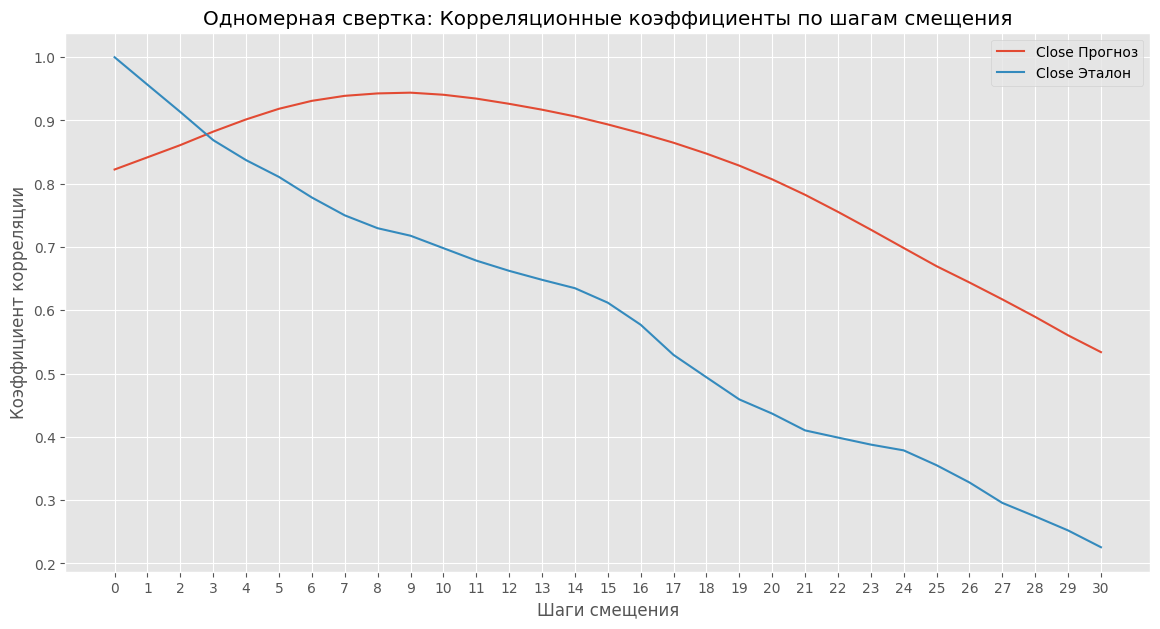

Обучение 20 эпох
Epoch 1/20
192/192 [==============================] - 2s 6ms/step - loss: 9.3342e-04 - val_loss: 0.0054
Epoch 2/20
192/192 [==============================] - 1s 6ms/step - loss: 5.7910e-04 - val_loss: 0.0332
Epoch 3/20
192/192 [==============================] - 1s 6ms/step - loss: 9.0188e-04 - val_loss: 0.0054
Epoch 4/20
192/192 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 5/20
192/192 [==============================] - 1s 6ms/step - loss: 8.3987e-04 - val_loss: 0.0090
Epoch 6/20
192/192 [==============================] - 1s 6ms/step - loss: 8.0434e-04 - val_loss: 0.0249
Epoch 7/20
192/192 [==============================] - 1s 6ms/step - loss: 9.2887e-04 - val_loss: 0.0295
Epoch 8/20
192/192 [==============================] - 1s 6ms/step - loss: 6.1155e-04 - val_loss: 0.0096
Epoch 9/20
192/192 [==============================] - 1s 6ms/step - loss: 7.5628e-04 - val_loss: 0.0092
Epoch 10/20
192/192 [==============================

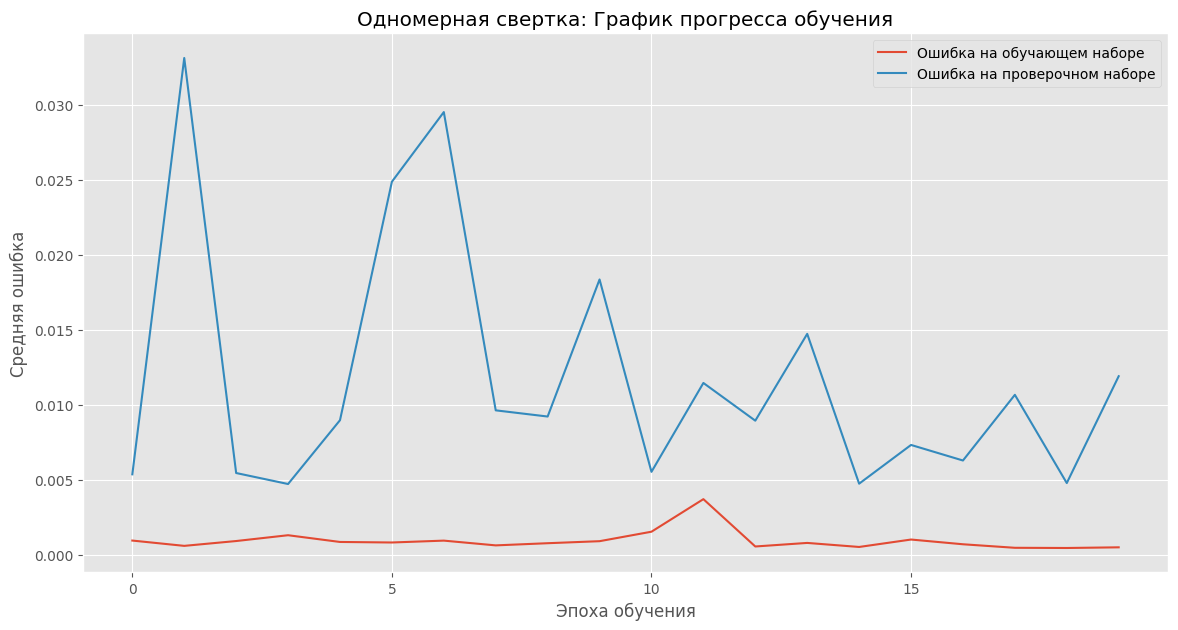

7/7 [==============================] - 0s 2ms/step


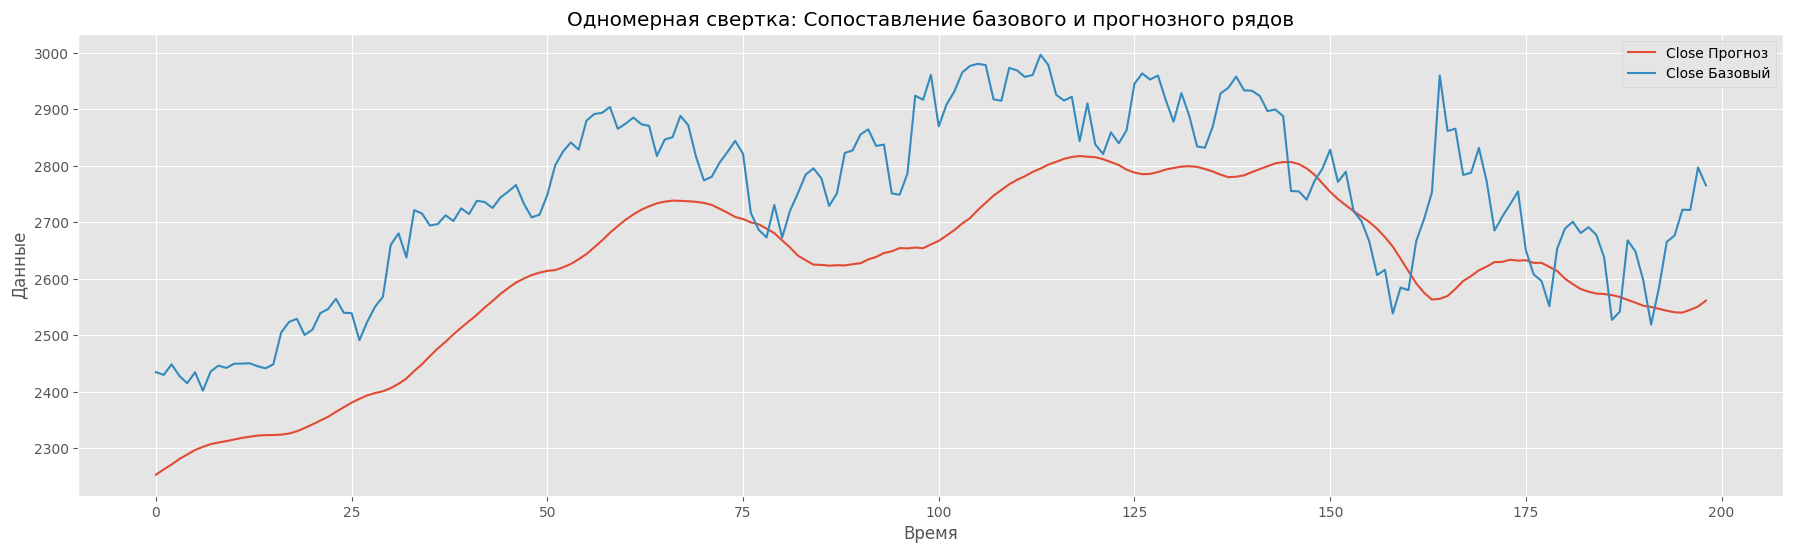

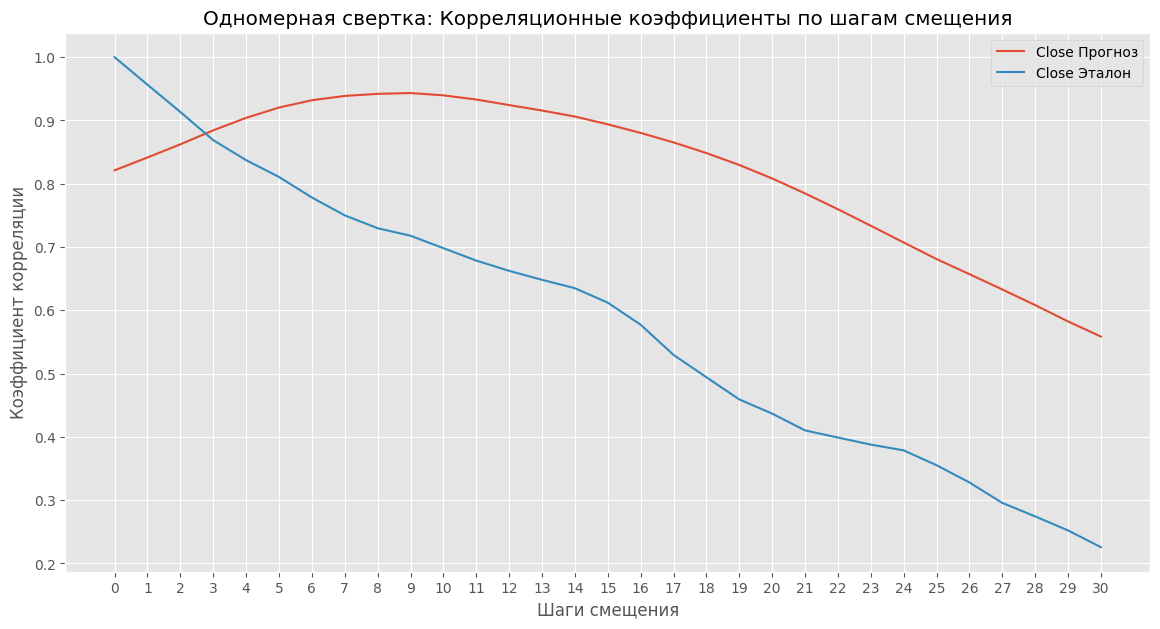

In [110]:
# Модель с одномерной сверткой
model_conv = Sequential()
model_conv.add(Conv1D(64, 5, input_shape=x_test.shape[1:], activation='relu'))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D())
model_conv.add(Flatten())
model_conv.add(Dense(100, activation='relu'))
model_conv.add(Dense(y_test.shape[1], activation='linear'))

# Обучение модели 50+20 эпох
train_eval_net(model_conv, train_datagen, val_datagen, [(50, Adam(lr=1e-4)),
                                                        (20, Adam(lr=1e-5))],
               x_test, y_test, y_scaler, title='Одномерная свертка')

**Топология 3 - Упрощенная модель с одномерной сверткой**

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 96, 50)            1300      
                                                                 
 flatten_3 (Flatten)         (None, 4800)              0         
                                                                 
 dense_6 (Dense)             (None, 10)                48010     
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 49,321
Trainable params: 49,321
Non-trainable params: 0
_________________________________________________________________
Обучение 40 эпох
Epoch 1/40
192/192 [==============================] - 1s 2ms/step - loss: 0.0490 - val_loss: 0.0144
Epoch 2/40
192/192 [==============================] - 0s 2ms/step

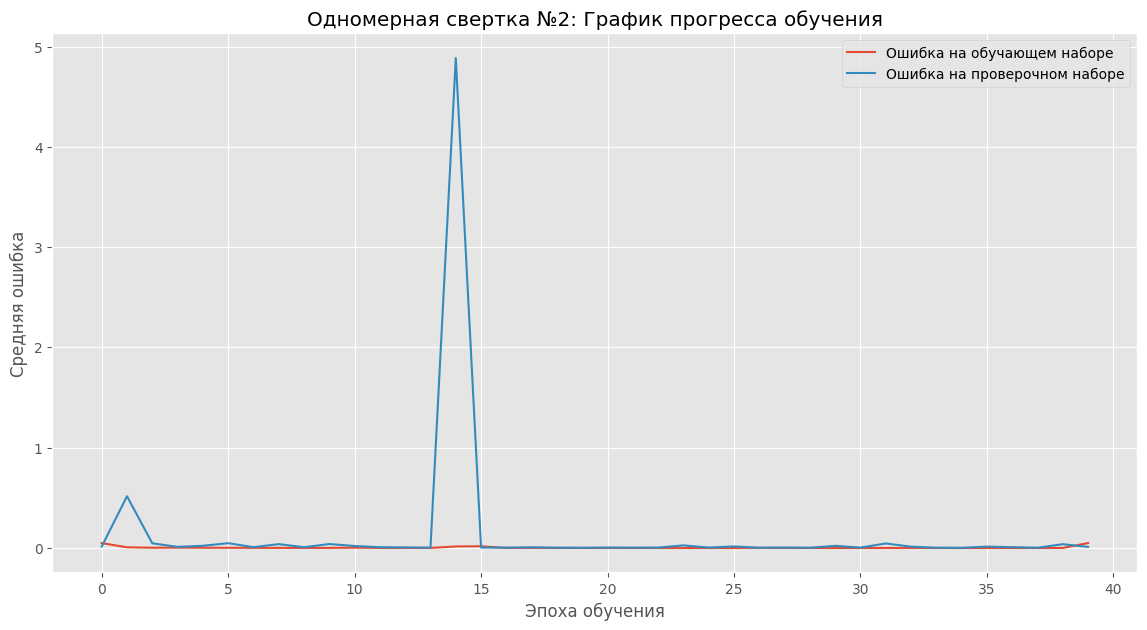

7/7 [==============================] - 0s 1ms/step


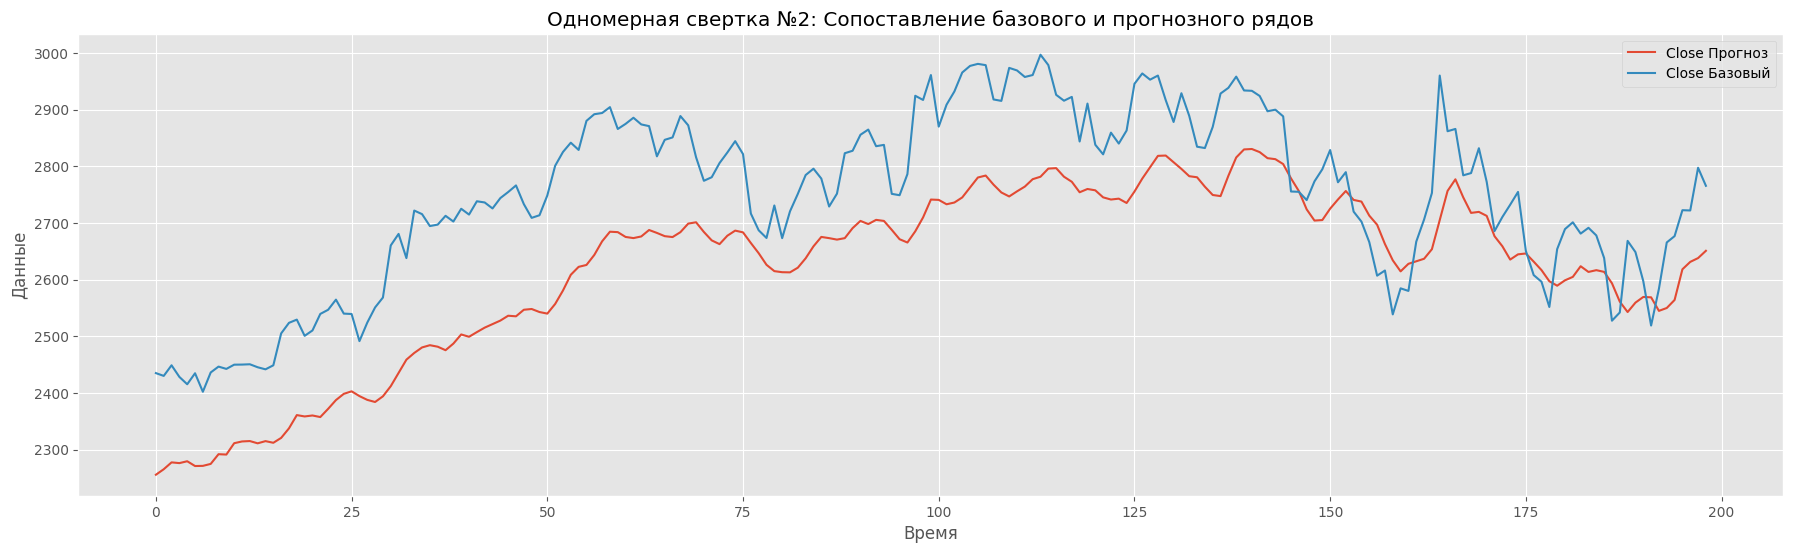

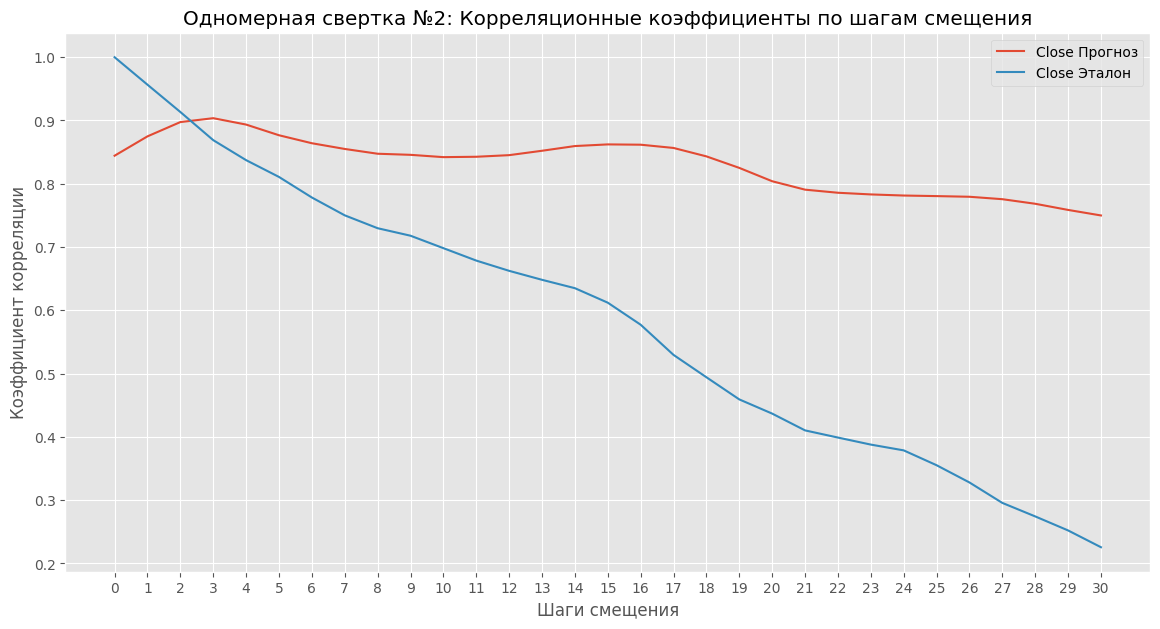

Обучение 40 эпох
Epoch 1/40
192/192 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0065
Epoch 2/40
192/192 [==============================] - 0s 2ms/step - loss: 4.5685e-04 - val_loss: 0.0030
Epoch 3/40
192/192 [==============================] - 0s 2ms/step - loss: 6.9699e-04 - val_loss: 0.0727
Epoch 4/40
192/192 [==============================] - 0s 2ms/step - loss: 3.5275e-04 - val_loss: 0.0098
Epoch 5/40
192/192 [==============================] - 0s 2ms/step - loss: 2.5160e-04 - val_loss: 0.0042
Epoch 6/40
192/192 [==============================] - 0s 2ms/step - loss: 3.4919e-04 - val_loss: 0.0037
Epoch 7/40
192/192 [==============================] - 0s 2ms/step - loss: 3.4934e-04 - val_loss: 0.0020
Epoch 8/40
192/192 [==============================] - 0s 2ms/step - loss: 1.7919e-04 - val_loss: 0.0025
Epoch 9/40
192/192 [==============================] - 0s 2ms/step - loss: 7.0596e-04 - val_loss: 0.0087
Epoch 10/40
192/192 [==============================

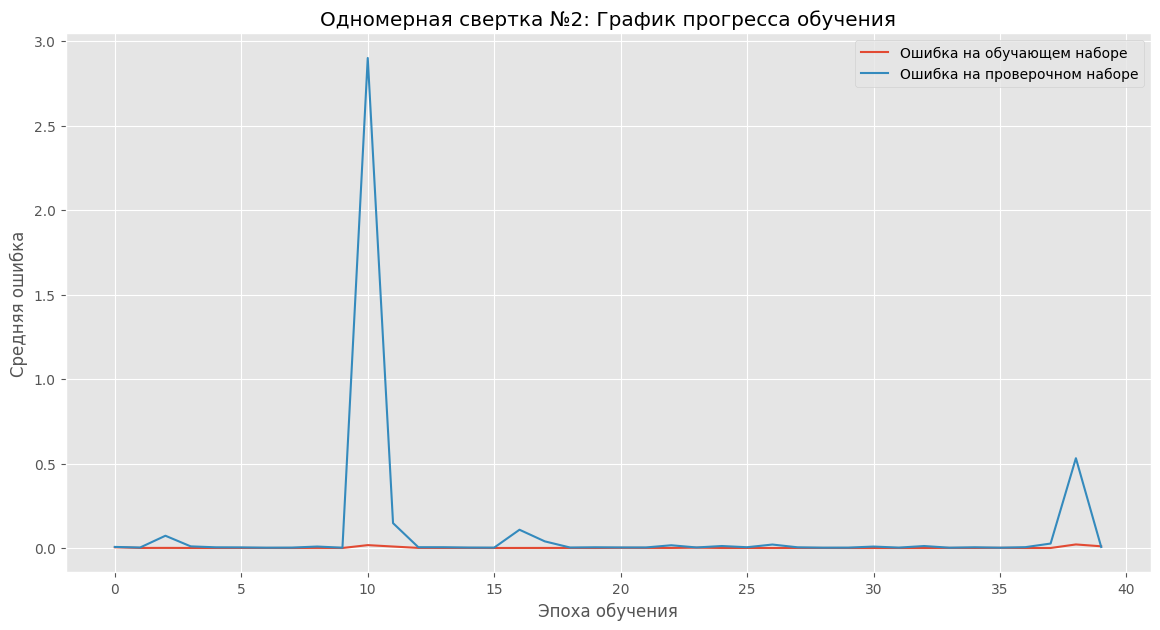

7/7 [==============================] - 0s 1ms/step


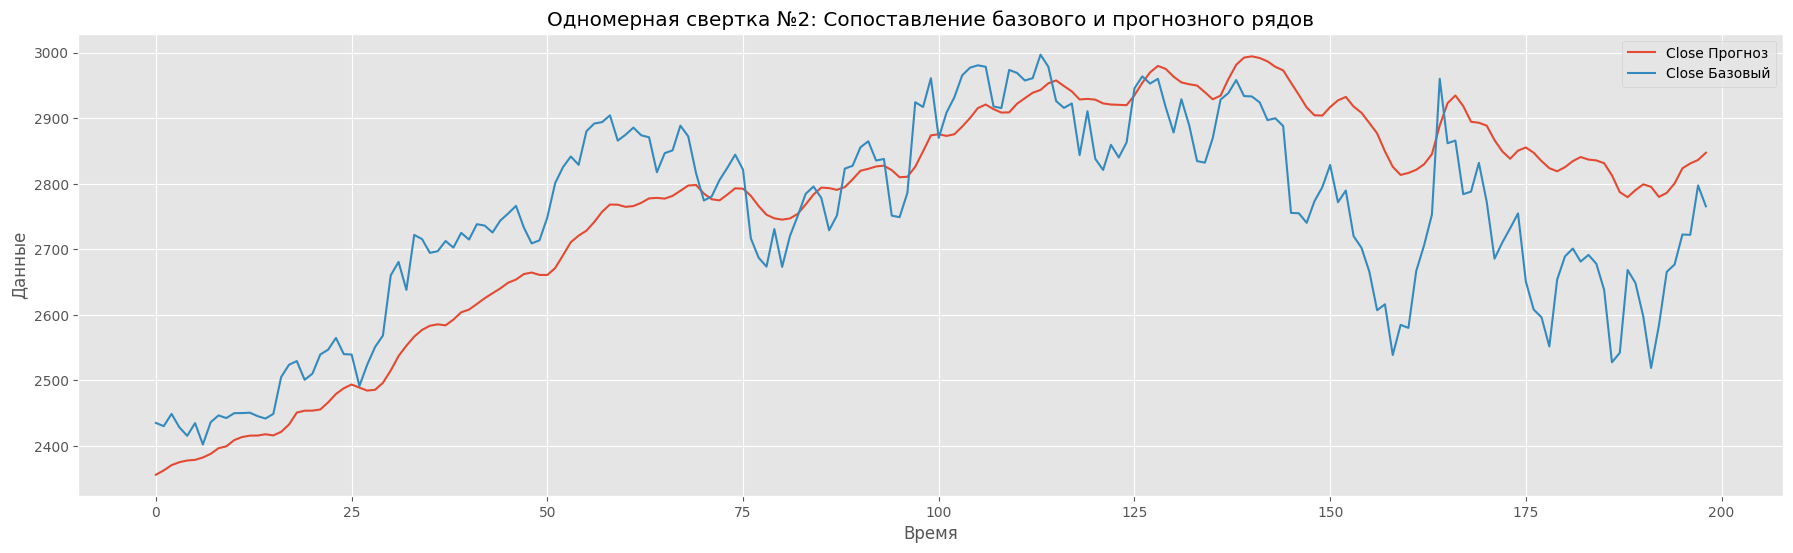

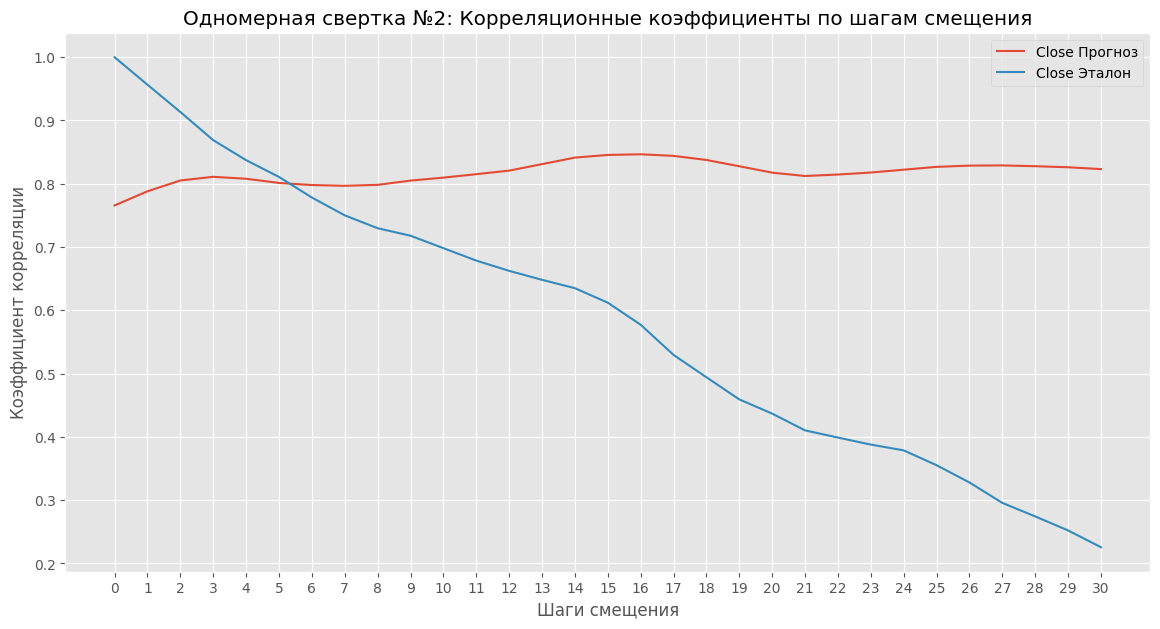

In [112]:
# Упрощенная модель с одномерной сверткой
model_conv_2 = Sequential()
model_conv_2.add(Conv1D(50, 5, input_shape=x_test.shape[1:], activation='linear'))
model_conv_2.add(Flatten())
model_conv_2.add(Dense(10, activation='linear'))
model_conv_2.add(Dense(y_test.shape[1], activation='linear'))

# Обучение модели 2x40 эпох
train_eval_net(model_conv_2, train_datagen, val_datagen, [(40, Adam(lr=1e-4)),
                                                          (40, Adam(lr=1e-5))],
               x_test, y_test, y_scaler, title='Одномерная свертка №2')

Возможны дальнейшие эксперименты по изменению гиперпараметров моделей, а также параметров их обучения.

Но уже на примерах трех нейросетевыхтопологий выше видно, что они позволяют достаточно точно прогнозировать временной ряд.

28/28 [==============================] - 0s 739us/step


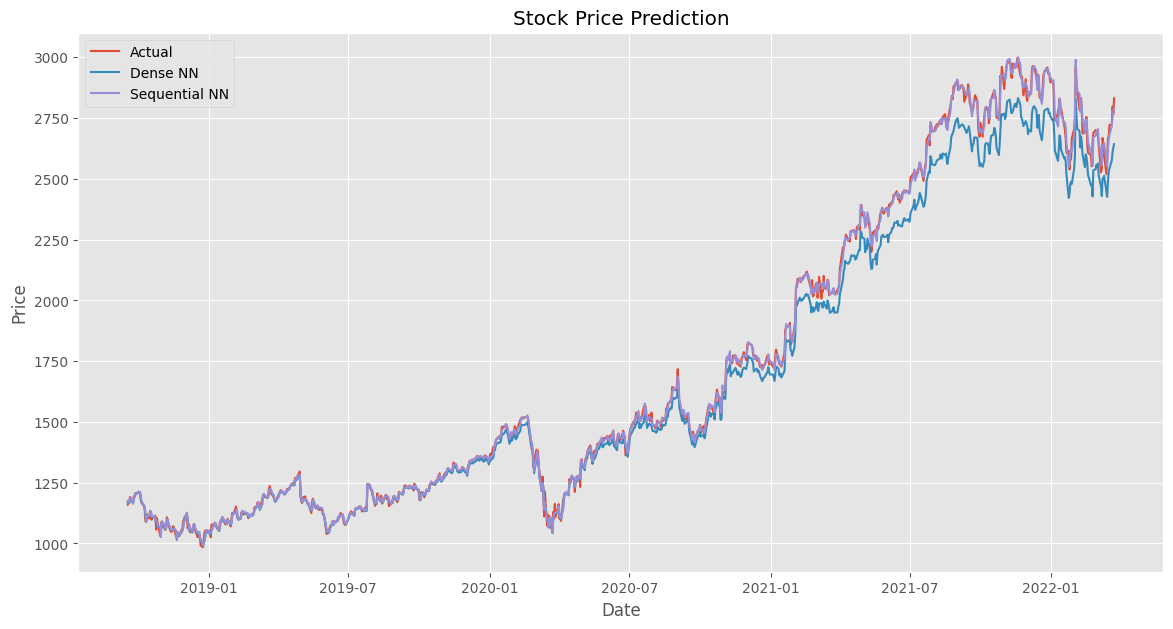

           Model  Accuracy
0       Dense NN  0.984972
1  Sequential NN  0.999241


In [178]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


X = data.drop(columns=['Close', 'Adj Close'])
y = data['Close'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# подготовим данные
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# функция для вычисления accuracy
def calculate_accuracy(y_true, y_pred):
    return 1 - mean_squared_error(y_true, y_pred) / np.var(y_true)

# Полносвязная (dense) нейронная сеть
model_dense = Sequential()
model_dense.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model_dense.add(Dense(32, activation='relu'))
model_dense.add(Dense(1, activation='linear'))
model_dense.compile(optimizer='adam', loss='mean_squared_error')
model_dense.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)
dense_pred = model_dense.predict(X_test_scaled)
dense_accuracy = calculate_accuracy(y_test, dense_pred)

# Полносвязная НС с дополнительными слоями
model_seq = Sequential()
model_seq.add(Conv1D(50, 4, input_shape=(X_train_scaled.shape[1], 1), activation='linear'))
model_seq.add(Flatten())
model_seq.add(Dense(64, activation='relu'))
model_seq.add(Dense(1, activation='linear'))
model_seq.compile(optimizer='adam', loss='mean_squared_error')
model_seq.fit(X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1), y_train, epochs=50, batch_size=32, verbose=0)
seq_pred = model_seq.predict(X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1))
seq_accuracy = calculate_accuracy(y_test, seq_pred)


# Построение графика
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], y_test, label='Actual')
plt.plot(data.index[-len(y_test):], dense_pred, label='Dense NN')
plt.plot(data.index[-len(y_test):], seq_pred, label='Sequential NN')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Результаты
accuracy_results = pd.DataFrame({
    'Model': ['Dense NN', 'Sequential NN'],
    'Accuracy': [dense_accuracy, seq_accuracy]
})

print(accuracy_results)